In [21]:
from __future__ import division, print_function, absolute_import

import sys
import numpy as np
import tensorflow as tf

from scipy import linalg
from scipy._lib.six import callable, get_method_function, get_function_code
from scipy.special import xlogy

In [4]:
"""
rbf - Radial basis functions for interpolation/smoothing scattered Nd data.
"""
__all__ = ['Rbf'] # export RBF class

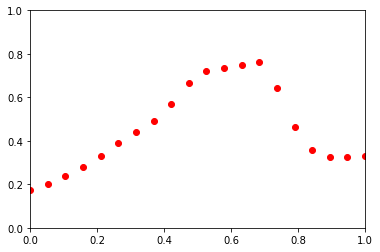

In [34]:
# # "Examples Usange"
# from scipy.interpolate import Rbf
# import matplotlib.pyplot as plt
# x, y, z, d = np.random.rand(4, 50)
# rbfi = Rbf(x, y, z, d, function='linear')  # radial basis function interpolator instance
# xi = yi = zi = np.linspace(0, 1, 20)
# di = rbfi(xi, yi, zi)   # interpolated values
# di.shape # (20,)
# plt.plot(xi, di, 'ro')
# plt.axis([0, 1, 0, 1])
# plt.show()

In [25]:
"""
Rbf(*args)
A class for radial basis function approximation/interpolation of
n-dimensional scattered data.
Parameters
----------
*args : arrays
    x, y, z, ..., d, where x, y, z, ... are the coordinates of the nodes
    and d is the array of values at the nodes
function : str or callable, optional
    The radial basis function, based on the radius, r, given by the norm
    (default is Euclidean distance); the default is 'multiquadric'::
        'multiquadric': sqrt((r/self.epsilon)**2 + 1)
        'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
        'gaussian': exp(-(r/self.epsilon)**2)
        'linear': r
        'cubic': r**3
        'quintic': r**5
        'thin_plate': r**2 * log(r)
    If callable, then it must take 2 arguments (self, r).  The epsilon
    parameter will be available as self.epsilon.  Other keyword
    arguments passed in will be available as well.
epsilon : float, optional
    Adjustable constant for gaussian or multiquadrics functions
    - defaults to approximate average distance between nodes (which is
    a good start).
smooth : float, optional
    Values greater than zero increase the smoothness of the
    approximation.  0 is for interpolation (default), the function will
    always go through the nodal points in this case.
norm : callable, optional
    A function that returns the 'distance' between two points, with
    inputs as arrays of positions (x, y, z, ...), and an output as an
    array of distance.  E.g, the default::
        def euclidean_norm(x1, x2):
            return sqrt( ((x1 - x2)**2).sum(axis=0) )
    which is called with x1=x1[ndims,newaxis,:] and
    x2=x2[ndims,:,newaxis] such that the result is a matrix of the
    distances from each point in x1 to each point in x2.

"""

"\nRbf(*args)\nA class for radial basis function approximation/interpolation of\nn-dimensional scattered data.\nParameters\n----------\n*args : arrays\n    x, y, z, ..., d, where x, y, z, ... are the coordinates of the nodes\n    and d is the array of values at the nodes\nfunction : str or callable, optional\n    The radial basis function, based on the radius, r, given by the norm\n    (default is Euclidean distance); the default is 'multiquadric'::\n        'multiquadric': sqrt((r/self.epsilon)**2 + 1)\n        'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)\n        'gaussian': exp(-(r/self.epsilon)**2)\n        'linear': r\n        'cubic': r**3\n        'quintic': r**5\n        'thin_plate': r**2 * log(r)\n    If callable, then it must take 2 arguments (self, r).  The epsilon\n    parameter will be available as self.epsilon.  Other keyword\n    arguments passed in will be available as well.\nepsilon : float, optional\n    Adjustable constant for gaussian or multiquadrics functions\n  

In [72]:
class CustomRbf(object):
    def _euclidean_norm(self, x1, x2):
        return np.sqrt(((x1 - x2)**2).sum(axis=0))

    def _h_linear(self, r):
        return r
    
    # Setup self._function and do smoke test on initial r
    def _init_function(self, r):
        self.function = self.function.lower()
        
        func_name = "_h_" + self.function
        self._function = getattr(self, func_name)
        a0 = self._function(r) # (50, 50)
        if a0.shape != r.shape:
            raise ValueError("Callable must take array and return array of the same shape")
        return a0

    def __init__(self, *args, **kwargs):
        # args[:-1] => except last element, d
        self.xi = np.asarray([np.asarray(a, dtype=np.float_).flatten() for a in args[:-1]])
        self.N = self.xi.shape[-1]
        self.di = np.asarray(args[-1]).flatten()

        if not all([x.size == self.di.size for x in self.xi]):
            raise ValueError("All arrays must be equal length.")

        self.norm = kwargs.pop('norm', self._euclidean_norm)
        print(self.xi.shape)
        self.r = self._call_norm(self.xi, self.xi)
        self.epsilon = kwargs.pop('epsilon', None)
        if self.epsilon is None:
            # default epsilon is the "the average distance between nodes" based on a bounding hypercube
            dim = self.xi.shape[0]
            ximax = np.amax(self.xi, axis=1) # ex) [ 0.95796556  0.97210597  0.98511454]
            ximin = np.amin(self.xi, axis=1) # ex) [ 0.0021079   0.00774162  0.00727649]
            edges = ximax-ximin # ex) [ 0.95585766  0.96436435  0.97783805]
            # nonzero => 요소들 중 0이 아닌 값들의 index 들을 반환해 주는 함수
            # 해당 edges는 모든 요소가 0이 아니므로 위의 edges와 아래의 edges는 같다.
            edges = edges[np.nonzero(edges)] 
            self.epsilon = np.power(np.prod(edges)/self.N, 1.0/edges.size)
        self.smooth = kwargs.pop('smooth', 0.0)

        self.function = kwargs.pop('function', 'multiquadric')
#         print(self.function) # linear

        # attach anything left in kwargs to self for use by any user-callable function or 
        # to save on the object returned. 
        for item, value in kwargs.items(): 
            setattr(self, item, value) # Not enter here!

        self.A = self._init_function(self.r) - np.eye(self.N)*self.smooth # r.shape (50, 50)
        self.nodes = linalg.solve(self.A, self.di)

    def _call_norm(self, x1, x2):
        if len(x1.shape) == 1:
            x1 = x1[np.newaxis, :]
        if len(x2.shape) == 1:
            x2 = x2[np.newaxis, :]
        x1 = x1[..., :, np.newaxis] # (3, 50) -> (3, 50, 1)
        x2 = x2[..., np.newaxis, :] # (3, 50) -> (3, 1, 50)
        return self.norm(x1, x2) # (50, 50)

    def __call__(self, *args):
        args = [np.asarray(x) for x in args]
        if not all([x.shape == y.shape for x in args for y in args]):
            raise ValueError("Array lengths must be equal")
        shp = args[0].shape
        xa = np.asarray([a.flatten() for a in args], dtype=np.float_)
        r = self._call_norm(xa, self.xi)
        return np.dot(self._function(r), self.nodes).reshape(shp)

In [75]:
tf_x = tf.convert_to_tensor(x, dtype=tf.float64)
tf_y = tf.convert_to_tensor(y, dtype=tf.float64)
tf_z = tf.convert_to_tensor(z, dtype=tf.float64)

In [78]:
tf_xi.shape

TensorShape([Dimension(3), Dimension(50)])

In [ ]:
def _euclidean_norm(self, x1, x2):
    return np.sqrt(((x1 - x2)**2).sum(axis=0))

In [129]:
def _tf_euclidean_norm(x1, x2):
    return tf.reduce_sum(tf.sqrt(((x1 - x2)**2)), 2)

In [139]:
tf.sqrt(((x1 - x2)**2))[0].eval()

<tf.Tensor 'strided_slice:0' shape=(50, 50) dtype=float64>

In [130]:
# (3, 50)
tf_xi = tf.stack([tf_x, tf_y, tf_z])
tf_xi_1 = tf.expand_dims(tf_xi, 2)
tf_xi_2 = tf.expand_dims(tf_xi, 1)
tf_r = _tf_euclidean_norm(tf_xi_1, tf_xi_2)
# tf_r = tf.norm(tf_xi, ord='euclidean', axis=0, keep_dims=False, name=None)

In [116]:
x1 = np.asarray([x, y, z])[..., :, np.newaxis]
x2 = np.asarray([x, y, z])[..., np.newaxis, :]

In [121]:
np.sqrt(((x1 - x2)**2)).shape

(3, 50, 50)

In [123]:
tf.reduce_sum(tf.sqrt(((x1 - x2)**2)), 0).shape

TensorShape([Dimension(50), Dimension(50)])

In [137]:
np.all( tf.reduce_sum(tf.sqrt(((x1 - x2)**2)), 0, keep_dims=True).eval() - np.sqrt(((x1 - x2)**2).sum(axis=0)) == 0)

False

In [104]:
rbfi.r

array([[ 0.        ,  0.41510694,  0.76557084, ...,  0.6168975 ,
         0.83155214,  0.57182998],
       [ 0.41510694,  0.        ,  0.54193483, ...,  0.58595942,
         0.6693379 ,  0.57213628],
       [ 0.76557084,  0.54193483,  0.        , ...,  1.11970501,
         0.84594652,  0.38443597],
       ..., 
       [ 0.6168975 ,  0.58595942,  1.11970501, ...,  0.        ,
         1.00295988,  1.05703908],
       [ 0.83155214,  0.6693379 ,  0.84594652, ...,  1.00295988,
         0.        ,  1.00620394],
       [ 0.57182998,  0.57213628,  0.38443597, ...,  1.05703908,
         1.00620394,  0.        ]])

In [103]:
tf_r.eval()

array([[ 0.        ,  0.62965504,  1.08352177, ...,  0.86106535,
         1.19146747,  0.85136743],
       [ 0.62965504,  0.        ,  0.91052445, ...,  1.01246757,
         1.15175334,  0.88181846],
       [ 1.08352177,  0.91052445,  0.        , ...,  1.92299202,
         1.05657014,  0.52034394],
       ..., 
       [ 0.86106535,  1.01246757,  1.92299202, ...,  0.        ,
         1.49268759,  1.71243279],
       [ 1.19146747,  1.15175334,  1.05657014, ...,  1.49268759,
         0.        ,  1.38917452],
       [ 0.85136743,  0.88181846,  0.52034394, ...,  1.71243279,
         1.38917452,  0.        ]])

In [71]:
rbfi.r.shape

(50, 50)

In [65]:
def linearRBF(*args):
    

    
def CustomRbf(object):
    def _euclidean_norm(self, x1, x2):
        return np.sqrt(((x1 - x2)**2).sum(axis=0))

    def _h_linear(self, r):
        return r
    
    # Setup self._function and do smoke test on initial r
    def _init_function(self, r):
        self.function = self.function.lower()
        
        func_name = "_h_" + self.function
        self._function = getattr(self, func_name)
        a0 = self._function(r) # (50, 50)
        if a0.shape != r.shape:
            raise ValueError("Callable must take array and return array of the same shape")
        return a0

    def __init__(self, *args, **kwargs):
        # args[:-1] => except last element, d
        self.xi = np.asarray([np.asarray(a, dtype=np.float_).flatten() for a in args[:-1]])
        self.N = self.xi.shape[-1]
        self.di = np.asarray(args[-1]).flatten()

        if not all([x.size == self.di.size for x in self.xi]):
            raise ValueError("All arrays must be equal length.")

        self.norm = kwargs.pop('norm', self._euclidean_norm)
        self.r = self._call_norm(self.xi, self.xi)
        self.epsilon = kwargs.pop('epsilon', None)
        if self.epsilon is None:
            # default epsilon is the "the average distance between nodes" based on a bounding hypercube
            dim = self.xi.shape[0]
            ximax = np.amax(self.xi, axis=1) # ex) [ 0.95796556  0.97210597  0.98511454]
            ximin = np.amin(self.xi, axis=1) # ex) [ 0.0021079   0.00774162  0.00727649]
            edges = ximax-ximin # ex) [ 0.95585766  0.96436435  0.97783805]
            # nonzero => 요소들 중 0이 아닌 값들의 index 들을 반환해 주는 함수
            # 해당 edges는 모든 요소가 0이 아니므로 위의 edges와 아래의 edges는 같다.
            edges = edges[np.nonzero(edges)] 
            self.epsilon = np.power(np.prod(edges)/self.N, 1.0/edges.size)
        self.smooth = kwargs.pop('smooth', 0.0)

        self.function = kwargs.pop('function', 'multiquadric')
        print(self.function) # linear

        # attach anything left in kwargs to self for use by any user-callable function or 
        # to save on the object returned. 
        for item, value in kwargs.items(): 
            setattr(self, item, value) # Not enter here!

        self.A = self._init_function(self.r) - np.eye(self.N)*self.smooth # r.shape (50, 50)
        self.nodes = linalg.solve(self.A, self.di)

    def _call_norm(self, x1, x2):
        if len(x1.shape) == 1:
            x1 = x1[np.newaxis, :]
        if len(x2.shape) == 1:
            x2 = x2[np.newaxis, :]
        x1 = x1[..., :, np.newaxis] # (3, 50) -> (3, 50, 1)
        x2 = x2[..., np.newaxis, :] # (3, 50) -> (3, 1, 50)
        return self.norm(x1, x2) # (50, 50)

    def __call__(self, *args):
        args = [np.asarray(x) for x in args]
        if not all([x.shape == y.shape for x in args for y in args]):
            raise ValueError("Array lengths must be equal")
        shp = args[0].shape
        xa = np.asarray([a.flatten() for a in args], dtype=np.float_)
        r = self._call_norm(xa, self.xi)
        return np.dot(self._function(r), self.nodes).reshape(shp)

IndentationError: expected an indented block (<ipython-input-65-2c906de85233>, line 5)

In [73]:
# "Examples Usange"
import matplotlib.pyplot as plt
x, y, z, d = np.random.rand(4, 50)
rbfi = CustomRbf(x, y, z, d, function='linear')  # radial basis function interpolator instance
# xi = yi = zi = np.linspace(0, 1, 20)
# di = rbfi(xi, yi, zi)   # interpolated values
# di.shape # (20,)
# plt.plot(xi, di, 'ro')
# plt.axis([0, 1, 0, 1])
# plt.show()

(3, 50)


In [15]:
rbfi.nodes

(50,)

In [16]:
rbfi.A, rbfi.di

(array([[ 0.        ,  1.23608765,  0.64115199, ...,  0.93179603,
          1.00382912,  0.41260331],
        [ 1.23608765,  0.        ,  0.79073354, ...,  0.89985561,
          0.55287134,  0.99952799],
        [ 0.64115199,  0.79073354,  0.        , ...,  0.8416919 ,
          0.87757442,  0.58983222],
        ..., 
        [ 0.93179603,  0.89985561,  0.8416919 , ...,  0.        ,
          0.83469331,  1.01097731],
        [ 1.00382912,  0.55287134,  0.87757442, ...,  0.83469331,
          0.        ,  0.73356184],
        [ 0.41260331,  0.99952799,  0.58983222, ...,  1.01097731,
          0.73356184,  0.        ]]),
 array([ 0.49160599,  0.12938456,  0.30019097,  0.61767145,  0.40779301,
         0.68039477,  0.5664044 ,  0.78909106,  0.80271959,  0.68905749,
         0.35805022,  0.02314279,  0.22622383,  0.95835426,  0.20421891,
         0.72075174,  0.1439016 ,  0.66159104,  0.78901559,  0.48848783,
         0.81132225,  0.81259163,  0.91996269,  0.94257481,  0.19090937,
       

In [18]:
rbfi.di.shape

(50,)

In [ ]:
self.nodes = linalg.solve(self.A, self.di)

In [ ]:
sess = tf.InteractiveSession()
tf_A = tf.convert_to_tensor(rbfi.A, dtype=tf.float64)
tf_di = tf.convert_to_tensor(rbfi.di, dtype=tf.float64)
tf_di = tf.expand_dims(tf_di, 1)
tf_nodes = tf.matrix_solve(tf_A, tf_di)
# tf_nodes.eval() - rbfi.nodes

In [52]:
tf_A = tf.convert_to_tensor(rbfi.A, dtype=tf.float64)

In [62]:
tf_di = tf.convert_to_tensor(rbfi.di, dtype=tf.float64)

In [54]:
tf_di = tf.expand_dims(tf_di, 1)

In [61]:
tf_di.eval()

array([[ 0.49160599],
       [ 0.12938456],
       [ 0.30019097],
       [ 0.61767145],
       [ 0.40779301],
       [ 0.68039477],
       [ 0.5664044 ],
       [ 0.78909106],
       [ 0.80271959],
       [ 0.68905749],
       [ 0.35805022],
       [ 0.02314279],
       [ 0.22622383],
       [ 0.95835426],
       [ 0.20421891],
       [ 0.72075174],
       [ 0.1439016 ],
       [ 0.66159104],
       [ 0.78901559],
       [ 0.48848783],
       [ 0.81132225],
       [ 0.81259163],
       [ 0.91996269],
       [ 0.94257481],
       [ 0.19090937],
       [ 0.41358901],
       [ 0.58595213],
       [ 0.54861451],
       [ 0.26443823],
       [ 0.00147262],
       [ 0.48664712],
       [ 0.42955664],
       [ 0.46928111],
       [ 0.71496355],
       [ 0.21114637],
       [ 0.08619027],
       [ 0.80970824],
       [ 0.39579425],
       [ 0.71997886],
       [ 0.30525721],
       [ 0.28256671],
       [ 0.4506653 ],
       [ 0.87888539],
       [ 0.27649925],
       [ 0.43900253],
       [ 0

In [55]:
tf_nodes = tf.matrix_solve(tf_A, tf_di)

In [35]:
rbfi.nodes.shape

(50,)

In [36]:
sess = tf.InteractiveSession()

In [60]:
tf_nodes.eval() - rbfi.nodes

array([[  2.96984659e-15,  -1.04156619e+00,  -1.10529341e+00, ...,
         -3.52622975e-01,  -3.12907597e+00,  -2.60152241e+00],
       [  1.04156619e+00,   8.65973959e-15,  -6.37272202e-02, ...,
          6.88943216e-01,  -2.08750978e+00,  -1.55995622e+00],
       [  1.10529341e+00,   6.37272202e-02,   1.11022302e-14, ...,
          7.52670436e-01,  -2.02378256e+00,  -1.49622900e+00],
       ..., 
       [  3.52622975e-01,  -6.88943216e-01,  -7.52670436e-01, ...,
         -3.88578059e-16,  -2.77645300e+00,  -2.24889944e+00],
       [  3.12907597e+00,   2.08750978e+00,   2.02378256e+00, ...,
          2.77645300e+00,   1.68753900e-14,   5.27553558e-01],
       [  2.60152241e+00,   1.55995622e+00,   1.49622900e+00, ...,
          2.24889944e+00,  -5.27553558e-01,   1.15463195e-14]])

In [51]:
rbfi.nodes

array([-0.08641722,  0.95514897,  1.01887619, -0.96074589, -0.16906163,
       -2.06381114,  0.48788911, -1.20469071, -7.36545362, -0.24833534,
        1.57709232,  2.96475208,  3.05392901, -2.9977262 ,  1.45831535,
       -2.75103611,  1.2343249 , -0.07944182, -1.86312113,  2.92273763,
       -2.94205737, -4.08647013, -4.4809268 , -5.14616073,  1.17725816,
        0.49519107,  0.05427772, -1.77197691,  1.55372472,  9.54431957,
       -0.16743971, -0.19984073, -0.33592696, -0.54332665,  2.55890305,
        3.9528971 , -3.61324549,  2.08661869, -2.82188936,  2.6254173 ,
        2.73131917, -0.55711856, -2.69381203,  0.91239549, -0.77025027,
        1.95116591, -0.84174883,  0.26620575,  3.04265875,  2.51510519])